In [1]:
import pandas as pd
import numpy as np
import requests
import json
import time

## Importing the PubMed Dataset

This dataset is taken from the paper "Human symptoms-disease network". (https://doi.org/10.1038/ncomms5212)  
The dataset can also be downloaded here: https://static-content.springer.com/esm/art%3A10.1038%2Fncomms5212/MediaObjects/41467_2014_BFncomms5212_MOESM1045_ESM.txt

In [2]:
pm_data = pd.read_csv("data/pubmed_data.csv", sep='\t')

In [3]:
pm_data

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551
2,"Aging, Premature",HIV Infections,3,10.393654
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654
4,"Aging, Premature",Breast Neoplasms,1,3.464551
...,...,...,...,...
147973,Hirsutism,Tobacco Use Disorder,1,2.483722
147974,Hirsutism,Radius Fractures,1,2.483722
147975,Hirsutism,Burns,1,2.483722
147976,Hirsutism,Colles' Fracture,1,2.483722


## Adding the MeSH codes to the dataset

The dataset contains the MeSH symptom term, but not the equivalent unique MeSH code. Therefore the codes must be added to the dataset.

Creating a list of all of the MeSH terms that need to be encoded:

In [4]:
all_conditions = list(set(list(pm_data["MeSH Symptom Term"]) + list(pm_data["MeSH Disease Term"])))

In [5]:
print("There are", len(all_conditions), "different symptoms/diseases in the dataset.")

There are 4293 different symptoms/diseases in the dataset.


### Using the  MeSH RDF API

Defining the MeSH lookup RDF API for the descriptor headings:

In [6]:
api = "https://id.nlm.nih.gov/mesh/lookup/descriptor"

Using the API to retrieve the MeSH code for each of the MeSH terms in the dataset:

58 symptoms/diseases terms were not recognised by the API and could not be mapped to any MeSH code. However this is only 1.35% of the dataset, therefore these entries will simply be dropped.

In [7]:
print("Failed mappings: 58 | Failed mapping as percentage of dataset: 1.35%")

Failed mappings: 58 | Failed mapping as percentage of dataset: 1.35%


Saving the results from the API:

### Mapping the MeSH terms to their respective MeSH codes

In [8]:
conditions_map = pd.read_csv("code_maps/terms_to_mesh_pm_dict.csv")

In [9]:
conditions_map

,MeSH Term,MeSH Code
0,"Nephroma, Mesoblastic",D018201
1,Limbic Encephalitis,D020363
2,Penile Induration,D010411
3,Coma,D003128
4,Dental Fistula,D003751
...,...,...
4230,Bulimia Nervosa,D052018
4231,Parotid Neoplasms,D010307
4232,Urination Disorders,D014555
4233,Whooping Cough,D014917


Creating a dictionary for mapping from the csv file:

In [10]:
conditions_map = conditions_map.set_index("MeSH Term")["MeSH Code"].to_dict()

Mapping the terms to their respective codes:

In [11]:
pm_data["MeSH Disease Code"] = pm_data["MeSH Disease Term"].map(conditions_map)
pm_data["MeSH Symptom Code"] = pm_data["MeSH Symptom Term"].map(conditions_map)

Dropping the rows containing diseases/symptoms that could not be mapped:

In [12]:
pm_data = pm_data.dropna(axis=0, how="any")
pm_data = pm_data.reset_index(drop=True)

In [13]:
pm_data

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score,MeSH Disease Code,MeSH Symptom Code
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551,D018357,D019588
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551,D009976,D019588
2,"Aging, Premature",HIV Infections,3,10.393654,D015658,D019588
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654,D000163,D019588
4,"Aging, Premature",Breast Neoplasms,1,3.464551,D001943,D019588
...,...,...,...,...,...,...
140518,Hirsutism,Tobacco Use Disorder,1,2.483722,D014029,D006628
140519,Hirsutism,Radius Fractures,1,2.483722,D011885,D006628
140520,Hirsutism,Burns,1,2.483722,D002056,D006628
140521,Hirsutism,Colles' Fracture,1,2.483722,D003100,D006628


## Mapping the MeSH codes to UMLS Codes

UMLS codes (Unified Medical Language System) are a standardised way of representing the diseases. Therefore the different codes used by different datasets will all be standardised to UMLS. The UMLS Metathesaurus API will be needed to map the MeSH code to UMLS codes.

Finding every unique MeSH code in the PubMed dataset:

In [14]:
all_mesh = list(pd.concat([pm_data["MeSH Disease Code"], pm_data["MeSH Symptom Code"]]).unique())

Define the UMLS API URI:

In [15]:
api = "https://uts-ws.nlm.nih.gov/rest/search/current"
apiKey = json.load(open("../umls_api_key.json"))["apiKey"]

Finding the respective UMLS code for every MeSH code in the PubMed dataset:

One code was failed to be mapped:

In [16]:
print("['D018290']")

['D018290']


Fixing it manually:

Saving the results so they can be reused:

In [17]:
mesh_to_umls_df = pd.read_csv("code_maps/mesh_to_umls_pm_dict.csv")
mesh_to_umls = mesh_to_umls_df.set_index("MeSH Code")["UMLS Code"].to_dict()

In [18]:
mesh_to_umls_df.head()

,MeSH Code,UMLS Code
0,D018357,C0035235
1,D009976,C0276357
2,D015658,C0019693
3,D000163,C0001175
4,D001943,C1257931


Using the generated dictionary to map the MeSH codes to UMLS codes:

In [19]:
pm_data["UMLS Disease Code"] = pm_data["MeSH Disease Code"].map(mesh_to_umls)
pm_data["UMLS Symptom Code"] = pm_data["MeSH Symptom Code"].map(mesh_to_umls)

In [20]:
pm_data

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score,MeSH Disease Code,MeSH Symptom Code,UMLS Disease Code,UMLS Symptom Code
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551,D018357,D019588,C0035235,C0231341
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551,D009976,D019588,C0276357,C0231341
2,"Aging, Premature",HIV Infections,3,10.393654,D015658,D019588,C0019693,C0231341
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654,D000163,D019588,C0001175,C0231341
4,"Aging, Premature",Breast Neoplasms,1,3.464551,D001943,D019588,C1257931,C0231341
...,...,...,...,...,...,...,...,...
140518,Hirsutism,Tobacco Use Disorder,1,2.483722,D014029,D006628,C0028043,C0019572
140519,Hirsutism,Radius Fractures,1,2.483722,D011885,D006628,C0034628,C0019572
140520,Hirsutism,Burns,1,2.483722,D002056,D006628,C0006434,C0019572
140521,Hirsutism,Colles' Fracture,1,2.483722,D003100,D006628,C0009353,C0019572


## Removing rows where the disease is the same as the symptom

Because a particular condition could be recorded as both a disease and a symptom, the datasets includes records of co-occurences of a disease with itself - with an extremely high TFIDF score. These associations add no information to the knowledge graph, thus they are removed.

In [21]:
pm_data[(pm_data["UMLS Disease Code"]==pm_data["UMLS Symptom Code"])].head()

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score,MeSH Disease Code,MeSH Symptom Code,UMLS Disease Code,UMLS Symptom Code
7725,Fetal Macrosomia,Fetal Macrosomia,581,1938.633227,D005320,D005320,C0015938,C0015938
12830,Obesity,Obesity,50200,41794.193312,D009765,D009765,C0028754,C0028754
13681,"Obesity, Morbid","Obesity, Morbid",3011,5278.102197,D009767,D009767,C0028756,C0028756
14130,"Cardiac Output, High","Cardiac Output, High",81,310.756006,D016534,D016534,C0085128,C0085128
14457,"Cardiac Output, Low","Cardiac Output, Low",2997,6421.958562,D002303,D002303,C0007166,C0007166


In [22]:
pm_data = pm_data[~(pm_data["UMLS Disease Code"]==pm_data["UMLS Symptom Code"])].reset_index(drop=True)

## Reshaping the dataset to be suitable for import to Gephi

The data must be reshaped into two different tables: one containing all of the nodes and their labels, and another describing the edges between the given nodes.

In [23]:
pm_data = pd.read_csv("data/pubmed_data_final.csv")

### Creating a "nodes" table

Creating a dataframe that contains only each "node", i.e. each disease or symptom, and its associated UMLS code. Starting by including all of the diseases:

In [24]:
nodes_table = pm_data.copy()[["UMLS Disease Code", "MeSH Disease Term"]]
nodes_table.columns = ["Id", "Label"]

Then adding all of the symptoms to the table:

In [25]:
nodes_table = pd.concat([nodes_table, pm_data[["UMLS Symptom Code", "MeSH Symptom Term"]].rename(columns={"UMLS Symptom Code":"Id", "MeSH Symptom Term":"Label"})])

241 conditions exist as both a symptom and a disease, thus the duplicate diseases/symptoms must be removed:

In [26]:
len(set(pm_data["UMLS Disease Code"]).intersection(set(pm_data["UMLS Symptom Code"])))

241

In [27]:
nodes_table = nodes_table.drop_duplicates()

Checking that the UMLS codes are all correct:

In [28]:
nodes_table.nunique()

Id       4222
Label    4222
dtype: int64

In [29]:
pm_data

,MeSH Symptom Term,MeSH Disease Term,PubMed occurrence,TFIDF score,MeSH Disease Code,MeSH Symptom Code,UMLS Disease Code,UMLS Symptom Code
0,"Aging, Premature",Respiratory Syncytial Virus Infections,1,3.464551,D018357,D019588,C0035235,C0231341
1,"Aging, Premature",Orthomyxoviridae Infections,1,3.464551,D009976,D019588,C0276357,C0231341
2,"Aging, Premature",HIV Infections,3,10.393654,D015658,D019588,C0019693,C0231341
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,3,10.393654,D000163,D019588,C0001175,C0231341
4,"Aging, Premature",Breast Neoplasms,1,3.464551,D001943,D019588,C1257931,C0231341
...,...,...,...,...,...,...,...,...
140275,Hirsutism,Tobacco Use Disorder,1,2.483722,D014029,D006628,C0028043,C0019572
140276,Hirsutism,Radius Fractures,1,2.483722,D011885,D006628,C0034628,C0019572
140277,Hirsutism,Burns,1,2.483722,D002056,D006628,C0006434,C0019572
140278,Hirsutism,Colles' Fracture,1,2.483722,D003100,D006628,C0009353,C0019572


Adding an optional column, indicating whether a condition is either a disease or symptom. The classification is not clear cut, because some conditions can exist as either a disease or a symptom. "Symptom" is chosen to take priority, due to the fewer number of symptoms in the dataset.

In [30]:
print("Number of symptoms:", pm_data["MeSH Symptom Term"].nunique(), 
"\nNumber of diseases:", pm_data["MeSH Disease Term"].nunique(), 
"\nNumber of conditions existing as both a symptom and disease:", len(set(pm_data["MeSH Symptom Term"]).intersection(set(pm_data["MeSH Disease Term"]))))

Number of symptoms: 316 
Number of diseases: 4147 
Number of conditions existing as both a symptom and disease: 241


In [31]:
nodes_table["condition"] = nodes_table["Id"].isin(pm_data["UMLS Symptom Code"].unique()).replace({True: "symptom", False: "disease"})

In [32]:
nodes_table

,Id,Label,condition
0,C0035235,Respiratory Syncytial Virus Infections,disease
1,C0276357,Orthomyxoviridae Infections,disease
2,C0019693,HIV Infections,disease
3,C0001175,Acquired Immunodeficiency Syndrome,disease
4,C1257931,Breast Neoplasms,disease
...,...,...,...
135787,C0020438,Hypercalciuria,symptom
135889,C0028734,Nocturia,symptom
136642,C0242453,Prostatism,symptom
139665,C1313921,Urinoma,symptom


There are 4222 unique diseases/symptoms in the PubMed dataset.

In [33]:
nodes_table.shape

(4222, 3)

### Creating an "edges" table

In [34]:
edges_table = pm_data.copy()[["MeSH Symptom Term", "MeSH Disease Term", "TFIDF score", "UMLS Disease Code", "UMLS Symptom Code"]]

Creating columns for:  
* the source and target of the edge (the two nodes)
* the label for the edge 
* the unique id for the edge
* the type of edge (directed)
* the weight of the edge - I choose to  use the tfidf score for the edge weights

In [35]:
edges_table

,MeSH Symptom Term,MeSH Disease Term,TFIDF score,UMLS Disease Code,UMLS Symptom Code
0,"Aging, Premature",Respiratory Syncytial Virus Infections,3.464551,C0035235,C0231341
1,"Aging, Premature",Orthomyxoviridae Infections,3.464551,C0276357,C0231341
2,"Aging, Premature",HIV Infections,10.393654,C0019693,C0231341
3,"Aging, Premature",Acquired Immunodeficiency Syndrome,10.393654,C0001175,C0231341
4,"Aging, Premature",Breast Neoplasms,3.464551,C1257931,C0231341
...,...,...,...,...,...
140275,Hirsutism,Tobacco Use Disorder,2.483722,C0028043,C0019572
140276,Hirsutism,Radius Fractures,2.483722,C0034628,C0019572
140277,Hirsutism,Burns,2.483722,C0006434,C0019572
140278,Hirsutism,Colles' Fracture,2.483722,C0009353,C0019572


In [36]:
edges_table.columns = ["symptom", "disease", "Weight", "Source", "Target"]
edges_table["Label"] = "Edge from " + edges_table["disease"] + " to " + edges_table["symptom"]
edges_table["Id"] = edges_table["Source"] + "_" + edges_table["Target"]
edges_table["Type"] = "Directed"

In [37]:
edges_table = edges_table[["Source", "Target", "Type", "Id", "Label", "Weight"]]
edges_table

,Source,Target,Type,Id,Label,Weight
0,C0035235,C0231341,Directed,C0035235_C0231341,Edge from Respiratory Syncytial Virus Infectio...,3.464551
1,C0276357,C0231341,Directed,C0276357_C0231341,Edge from Orthomyxoviridae Infections to Aging...,3.464551
2,C0019693,C0231341,Directed,C0019693_C0231341,"Edge from HIV Infections to Aging, Premature",10.393654
3,C0001175,C0231341,Directed,C0001175_C0231341,Edge from Acquired Immunodeficiency Syndrome t...,10.393654
4,C1257931,C0231341,Directed,C1257931_C0231341,"Edge from Breast Neoplasms to Aging, Premature",3.464551
...,...,...,...,...,...,...
140275,C0028043,C0019572,Directed,C0028043_C0019572,Edge from Tobacco Use Disorder to Hirsutism,2.483722
140276,C0034628,C0019572,Directed,C0034628_C0019572,Edge from Radius Fractures to Hirsutism,2.483722
140277,C0006434,C0019572,Directed,C0006434_C0019572,Edge from Burns to Hirsutism,2.483722
140278,C0009353,C0019572,Directed,C0009353_C0019572,Edge from Colles' Fracture to Hirsutism,2.483722


There are 140,523 connections between diseases and symptoms in the PubMed dataset.

In [38]:
edges_table.shape

(140280, 6)

Most of the diseases in the PubMed dataset are associated only with very few symptoms, however there are many diseases with up to 50, or even 100 symptoms associated with them.

<AxesSubplot:ylabel='Frequency'>

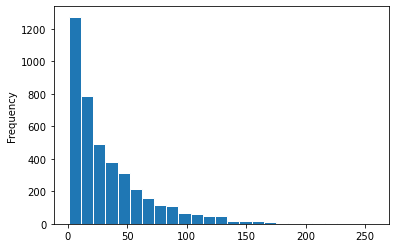

In [39]:
edges_table.groupby("Source").count()["Target"].plot.hist(edgecolor="white", bins=25)

Saving the nodes and edges table as csv, for import to Gephi:

## References

Zhou, X., Menche, J., Barabási, A. L., & Sharma, A. (2014). Human symptoms–disease network. Nature communications, 5(1), 1-10. Dataset released under Creative Commons Attribution v4.0 International licence.  

MeSH RDF API: https://id.nlm.nih.gov/mesh/swagger/ui  
MeSH RDF API Technical Documentation: https://hhs.github.io/meshrdf/index.html  

The UMLS API: https://documentation.uts.nlm.nih.gov/rest/search/#searchType  
*This product uses publicly available data from the U.S. National Library of Medicine (NLM), National Institutes of Health, Department of Health and Human Services; NLM is not responsible for the product and does not endorse or recommend this or any other product.*